In [1]:
from utils.ETC import *
from utils.Plot import *
from mpl_toolkits.mplot3d import Axes3D

In [2]:
username = 'asas4539@hanyang.ac.kr'
password = 'onsaemiro1729!!'
norad_cat_ids = ["25544", "58932"]  # 예: 국제 우주 정거장(ISS) 등의 NORAD Catalog ID

tle_dict = get_spacetrack_tles(username, password, norad_cat_ids)

if tle_dict:
    for norad_cat_id, tle in tle_dict.items():
        if tle:
            first_line, second_line = tle
            print(f"{norad_cat_id}의 TLE 데이터:")
            print(first_line)
            print(second_line)
        else:
            print(f"{norad_cat_id}의 TLE 데이터를 가져오지 못했습니다.")

25544의 TLE 데이터:
1 25544U 98067A   24173.19732074  .00016476  00000-0  29986-3 0  9991
2 25544  51.6401 295.4229 0010595 349.6774  10.3996 15.49586846459172
58932의 TLE 데이터:
1 58932U 24027B   24172.76392037  .00011364  00000-0  42221-3 0  9994
2 58932  53.1589 341.6062 0001176 106.1435 253.9695 15.28027647 21348


In [3]:
satellite, period_of_satellite_in_seconds= cal_satellite_period(tle_dict["58932"][0],tle_dict["58932"][1])

Radian: 0.0667
Degree: 3.8201
Orbital period(min): 94.2391
Orbital period(sec): 5654.3480


In [4]:
error_code, positions, velocities = cal_kinematics_vector_periods(satellite, period_of_satellite_in_seconds, True)

2024-06-20 18:20:02 S: (6509.4083964674355, -2168.07141861248, -4.387539800654005) V: (1.4406775955811906, 4.336889985584561, 6.103893749649675)
Altitude: 6860.9730
2024-06-20 18:21:02 S: (6581.3079476895555, -1903.2294130533367, 361.5830306139759) V: (0.9550801579543745, 4.487913827670868, 6.090606148135554)
Altitude: 6860.5130
2024-06-20 18:22:02 S: (6623.930878392756, -1629.9209677116096, 725.940564463129) V: (0.4651533702474082, 4.618996900143145, 6.050144492779819)
Altitude: 6860.0359
2024-06-20 18:23:02 S: (6637.083170415735, -1349.3607919695298, 1087.0592129607032) V: (-0.02690843436227886, 4.729545778132521, 5.982682480071993)
Altitude: 6859.5441
2024-06-20 18:24:02 S: (6620.702832771741, -1062.7964214999854, 1443.3272467807606) V: (-0.5189004531262952, 4.819060173357503, 5.88851693555875)
Altitude: 6859.0404
2024-06-20 18:25:02 S: (6574.860215741177, -771.5025558788279, 1793.1544047697485) V: (-1.0086179075013044, 4.887135317360257, 5.768066401107492)
Altitude: 6858.5280
2024-

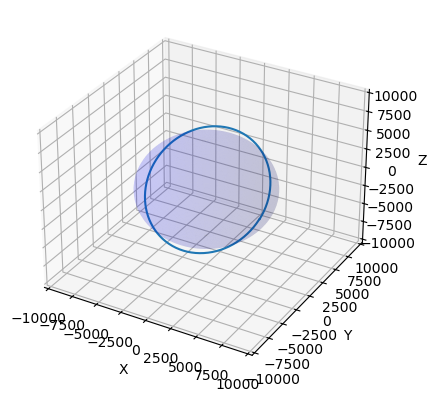

In [5]:
plot_orbit(positions)